In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
import pickle
sns.reset_orig()
sns.set_palette('crest')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from models import get_models

# Set the output directories here
outdir_10 = 'outdir_10_percent_threshold'
outdir_20 = 'outdir_20_percent_threshold'

In [2]:
with open(f'../catalogue/catalogue.pkl', 'rb') as f:
    catalogue = pickle.load(f)
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.iloc[:, :].idxmax(axis=1) if var == 'log_evidence' else results.iloc[:, :].idxmin(axis=1)
    return results
results_10 = load_results(outdir_10, 'log_evidence')
results_20 = load_results(outdir_20, 'log_evidence')
results_10_bf = results_10.drop(columns='best_fitting').sub(results_10['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_20_bf = results_20.drop(columns='best_fitting').sub(results_20['simple_power_law'], axis=0).drop(columns='simple_power_law')
with open(f'../output/results_param_estimates_from_{outdir_10}.json', 'r', encoding='utf-8-sig') as f:
    param_est_10 = json.load(f)
with open(f'../output/results_param_estimates_from_{outdir_20}.json', 'r', encoding='utf-8-sig') as f:
    param_est_20 = json.load(f)

Systematic error distribution:


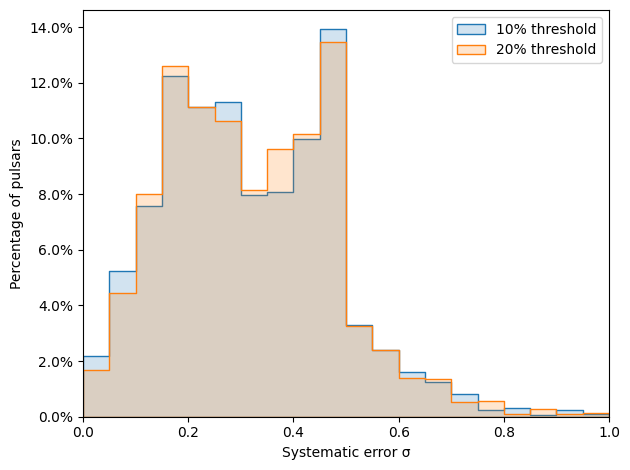

Systematic errors > 0.5 (10% threshold): 458 / 4380
Systematic errors > 0.5 (20% threshold): 447 / 4380


In [3]:
print('Systematic error distribution:')
    
model_dict = get_models('simple_power_law;broken_power_law;log_parabolic_spectrum;high_frequency_cut_off_power_law;low_frequency_turn_over_power_law')

sigma_10, sigma_20 = {}, {}
for model in model_dict:
    sigma_10[model], sigma_20[model] = [], []
    for jname in results_10.index:
        if jname not in catalogue.cat_dict or model not in param_est_10[jname]:
            continue
        sigma_10[model].append(param_est_10[jname][model]['median'][-1])
    for jname in results_20.index:
        if jname not in catalogue.cat_dict or model not in param_est_20[jname]:
            continue
        sigma_20[model].append(param_est_20[jname][model]['median'][-1])  # the last parameter is the error
        
sigma_all_10 = np.concatenate([sigma_10[model] for model in model_dict])
sigma_all_20 = np.concatenate([sigma_20[model] for model in model_dict])

fig, ax = plt.subplots()
sns.histplot(sigma_all_10, binwidth=0.05, binrange=(0, 1), kde=False, label='10% threshold', stat='probability', element='step', color='tab:blue', alpha=0.2, ax=ax)
sns.histplot(sigma_all_20, binwidth=0.05, binrange=(0, 1), kde=False, label='20% threshold', stat='probability', element='step', color='tab:orange', alpha=0.2, ax=ax)
ax.set_xlim(0, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel('Systematic error σ')
ax.set_ylabel('Percentage of pulsars')
ax.legend()
plt.tight_layout()
plt.savefig('Systematic error distribution.pdf', bbox_inches='tight')
plt.show()

print(f'Systematic errors > 0.5 (10% threshold): {np.sum(sigma_all_10 > 0.5)} / {len(sigma_all_10)}')
print(f'Systematic errors > 0.5 (20% threshold): {np.sum(sigma_all_20 > 0.5)} / {len(sigma_all_20)}')

In [4]:
print('Broken power law: how many of them are having only one point before or after ν_b?', end=' ')

cnt_bpl, cnt_bpl_filtered = 0, 0
for jname in results_10.index:
    if results_10.loc[jname, 'best_fitting'] == 'broken_power_law':
        cnt_bpl += 1
        ν_b = param_est_10[jname]['broken_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_b) <= 1 or np.sum(X_sorted > ν_b) <= 1:
            cnt_bpl_filtered += 1
print(f'{cnt_bpl_filtered} / {cnt_bpl}.')

print('Low-frequency turn-over power law: how many of them are having only one point before or after ν_c?', end=' ')

cnt_lfto, cnt_lfto_filtered = 0, 0
for jname in results_10.index:
    if results_10.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        cnt_lfto += 1
        ν_c = param_est_10[jname]['low_frequency_turn_over_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_c) <= 1 or np.sum(X_sorted > ν_c) <= 1:
            cnt_lfto_filtered += 1
print(f'{cnt_lfto_filtered} / {cnt_lfto}.')

Broken power law: how many of them are having only one point before or after ν_b? 99 / 287.
Low-frequency turn-over power law: how many of them are having only one point before or after ν_c? 39 / 104.
